### [ Model save & load ]
- 2가지 형태 저장
    * 전체 저장
    * 모델의 파라미터만 저장
- 2가지 형태 로딩
    * 전체 저장 모델 파일 ==> 로딩으로 사용 가능
    * 모델 파라미터 저장 파일 ==> 모델 인스턴스 생성 후 층별 파라미터 적용

[1] 모듈 로딩 및 데이터 준비<hr>

In [12]:
# ================================================================================
# [1-1] 모듈 로딩
# ================================================================================
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset

from sklearn.model_selection import train_test_split

from torchinfo import summary

from Utils import util_func_reg as uf

In [13]:
# ================================================================================
## [1-2] 데이터 준비
# ================================================================================
dataDF = pd.read_csv("../DATA/study_score_multi.csv")
print(dataDF.info())
print(dataDF.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   study_hours    5000 non-null   float64
 1   sleep_hours    5000 non-null   float64
 2   participation  5000 non-null   float64
 3   score          5000 non-null   float64
dtypes: float64(4)
memory usage: 156.4 KB
None
   study_hours  sleep_hours  participation  score
0         1.45         5.28           97.4   32.8
1         2.17         5.46           22.4   32.1
2         8.03         5.56           15.6   61.0
3         3.97         4.08           31.2   31.3
4         6.76         7.28           66.8   72.1


[2] 커스텀 Dataset 클래스 <hr>

In [14]:
# ================================================================================
# [2-1] 커스텀 데이터셋 클래스 정의
# ================================================================================
class CustomDataset(Dataset):
    def __init__(self, dataDF):
        super().__init__()

        # 피쳐
        self.x = dataDF[dataDF.columns[:-1]].values 
        # 타겟
        self.y = dataDF[dataDF.columns[3]].values

    def __len__(self):
        return self.x.shape[0]  # 행수
    
    def __getitem__(self, index):
        xTS = torch.tensor(self.x[index], dtype=torch.float32)
        yTS = torch.tensor(self.y[index], dtype=torch.float32)

        return xTS, yTS

In [15]:
# ================================================================================
# [2-2] 커스텀 데이터셋 인스턴스 생성 및 사용
# ================================================================================
allDS = CustomDataset(dataDF)

print(f"allDS : {len(allDS)}")

allDS : 5000


In [16]:
# ================================================================================
# [2-3] 학습용/검증용/테스트용 데이터셋 분리
# ================================================================================
# 타겟 리스트
targetList = allDS.y

# 전체 데이터 인덱스 리스트 생성
indexList = list(range(len(allDS)))

# 테스트용 데이터셋 분리
x_temp_idx, x_test_idx, y_temp, y_test = train_test_split(
    indexList,
    targetList,
    train_size=0.9,
    random_state=10
)

# 학습용/검증용 데이터셋 분리
x_train_idx, x_valid_idx, y_train, y_valid = train_test_split(
    x_temp_idx,
    y_temp,
    train_size=0.8,
    random_state=10
)

In [17]:
# ================================================================================
# [2-4] 학습용/검증용/테스트용 커스텀 데이터셋 생성 
# ================================================================================
trainDS = Subset(allDS, x_train_idx)
validDS = Subset(allDS, x_valid_idx)
testDS = Subset(allDS, x_test_idx)

print(f"allDS : {len(allDS)}, trainDS : {len(trainDS)}, validDS : {len(validDS)}, testDS : {len(testDS)}")

allDS : 5000, trainDS : 3600, validDS : 900, testDS : 500


[3] 모델 클래스 정의<hr>

In [18]:
# ================================================================================
# [3-1] 커스텀 모델 클래스 
# ================================================================================
class MultiModel(nn.Module):
    def __init__(self):

        super().__init__()
        self.hd1_layer = nn.Linear(3, 128)
        self.hd2_layer = nn.Linear(128, 64)
        self.hd3_layer = nn.Linear(64, 32)
        self.out_layer = nn.Linear(32, 1)

    def forward(self, data):
        
        # 입력층 -> 은닉층1
        out = F.relu(self.hd1_layer(data))

        # 은닉층1 -> 은닉층2
        out = F.relu(self.hd2_layer(out))

        # 은닉층2 -> 은닉층3
        out = F.relu(self.hd3_layer(out))

        # 은닉층3 -> 출력층
        out = self.out_layer(out)

        return out

In [19]:
# ================================================================================
# [3-2] 커스텀 모델 클래스 구조 확인
# ================================================================================
summary(MultiModel(), 
        input_size=(1, 3))

Layer (type:depth-idx)                   Output Shape              Param #
MultiModel                               [1, 1]                    --
├─Linear: 1-1                            [1, 128]                  512
├─Linear: 1-2                            [1, 64]                   8,256
├─Linear: 1-3                            [1, 32]                   2,080
├─Linear: 1-4                            [1, 1]                    33
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05

[4] 학습 준비<hr>

In [20]:
# ================================================================================
# [4-1] 학습 관련 설정
# ================================================================================
EPOCHS = 100
BATCH_SIZE = 20
LR = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
# ================================================================================
# [4-2] 학습 관련 인스턴스 생성
# ================================================================================
# 모델 생성
model = MultiModel().to(DEVICE)

# 손실함수(다중분류용)
lossFN = nn.MSELoss()

# 최적화
optimizer = optim.Adam(model.parameters(), lr=LR)

# 데이터로더 
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE)

print(f"trainDL : {len(trainDL)}, validDL : {len(validDL)}, testDL : {len(testDL)}")

scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              patience=3, factor=0.1, verbose=True)

trainDL : 180, validDL : 45, testDL : 25


c:\Users\khw27\anaconda3\envs\DL310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[5] 학습 진행 <HR>

In [22]:
HISTORY = {
    'train_loss' : [],  # 학습 손실값
    'val_loss'   : [],  # 검증 손실값
    'val_r2'     : [],  # 검증 R² 점수
    'val_mae'    : []   # 검증 MAE
}


for epoch in range(EPOCHS):


    train_loss = uf.train_one_epoch(
        model,
        trainDL,
        lossFN,
        optimizer,
        DEVICE
    )
    
    val_loss, val_r2, val_mae, val_rmse = uf.evaluate(
        model,
        validDL,
        lossFN,
        DEVICE
    )
    
    HISTORY['train_loss'].append(train_loss)
    HISTORY['val_loss'].append(val_loss)
    HISTORY['val_r2'].append(val_r2)
    HISTORY['val_mae'].append(val_mae)

    scheduler.step(val_loss)
    
    print(f"[EPOCH-{epoch:03}] : LOSS - Train : {train_loss:.5f}, Valid : {val_loss:.5f} / R² : {val_r2:.5f}, MAE : {val_mae:.5f}, RMSE : {val_rmse:.5f}")

[EPOCH-000] : LOSS - Train : 138.64521, Valid : 38.08614 / R² : 0.90967, MAE : 4.93760, RMSE : 6.17140
[EPOCH-001] : LOSS - Train : 47.87947, Valid : 37.10380 / R² : 0.91200, MAE : 4.85981, RMSE : 6.09129
[EPOCH-002] : LOSS - Train : 47.64522, Valid : 36.89730 / R² : 0.91249, MAE : 4.85865, RMSE : 6.07431
[EPOCH-003] : LOSS - Train : 45.68819, Valid : 47.26245 / R² : 0.88791, MAE : 5.49245, RMSE : 6.87477
[EPOCH-004] : LOSS - Train : 43.48032, Valid : 37.36569 / R² : 0.91138, MAE : 4.87921, RMSE : 6.11275
[EPOCH-005] : LOSS - Train : 41.77229, Valid : 36.89930 / R² : 0.91249, MAE : 4.85345, RMSE : 6.07448
[EPOCH-006] : LOSS - Train : 41.88609, Valid : 38.05954 / R² : 0.90974, MAE : 4.93375, RMSE : 6.16924
[EPOCH-007] : LOSS - Train : 37.52420, Valid : 36.83698 / R² : 0.91264, MAE : 4.84400, RMSE : 6.06935
[EPOCH-008] : LOSS - Train : 37.26101, Valid : 37.89962 / R² : 0.91012, MAE : 4.92114, RMSE : 6.15627
[EPOCH-009] : LOSS - Train : 37.66759, Valid : 37.45492 / R² : 0.91117, MAE : 4.9

[6] 시각화 <hr>

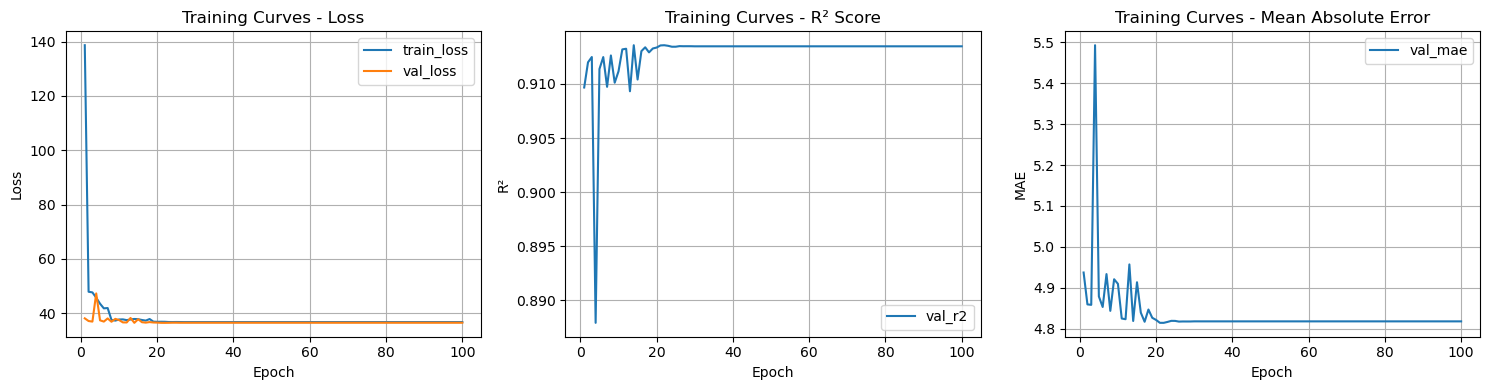

In [23]:
uf.plot_history(HISTORY)

In [24]:
# 테스트 세트 평가
test_loss, test_r2, test_mae, test_rmse = uf.evaluate(
    model,
    testDL,
    lossFN,
    DEVICE
)
print(f"\n[TEST RESULT]")
print(f"Loss : {test_loss:.5f}, R² : {test_r2:.5f}, MAE : {test_mae:.5f}, RMSE : {test_rmse:.5f}")


# 샘플 예측 결과 확인
uf.show_predictions(model, testDL, DEVICE, n=10)


[TEST RESULT]
Loss : 38.00268, R² : 0.92203, MAE : 4.98911, RMSE : 6.16463
Sample predictions:
- GT: 95.3000 | Pred: 89.0010 | Error: 6.2990
- GT: 66.8000 | Pred: 61.6850 | Error: 5.1150
- GT: 27.8000 | Pred: 24.0142 | Error: 3.7858
- GT: 68.4000 | Pred: 71.0266 | Error: 2.6266
- GT: 53.5000 | Pred: 53.9633 | Error: 0.4633
- GT: 68.4000 | Pred: 74.0148 | Error: 5.6148
- GT: 49.2000 | Pred: 49.5332 | Error: 0.3332
- GT: 53.7000 | Pred: 38.1942 | Error: 15.5058
- GT: 9.7000 | Pred: 18.0555 | Error: 8.3555
- GT: 83.9000 | Pred: 78.4686 | Error: 5.4314
